# Homework 4: GMMs

## Part 1: Gaussian Mixture Model and EM using scikit learn (10 points)

### Generate data
Generate 400 samples randomly split between 4 clusters.

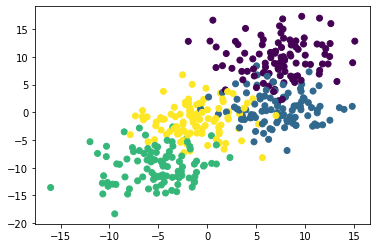

In [1]:
# Data generation process
%matplotlib inline

from sklearn.datasets.samples_generator import make_blobs
import numpy
import matplotlib.pyplot as plt
from tqdm import tqdm

random_seed = 8

X, Y = make_blobs(n_samples=400, centers=4, n_features=2, cluster_std=3,
                  random_state=random_seed)

plt.figure()
plt.scatter(X[:,0], X[:,1], c=Y)
plt.show()

### Train GMMs

Train GMMs on the data you generated with at least two different values for `covariance_type`.

In [2]:
# Use this GMM module from sklearn
from sklearn.mixture import GaussianMixture
k=4
#first gmm using diagonal covariance
gmm = GaussianMixture(n_components=k,covariance_type = "diag",random_state=random_seed)
gmm.fit(X,Y)
Z=gmm.predict(X)
C = gmm.means_
#second gmm using spherical covariance
gmm2 = GaussianMixture(n_components=k,covariance_type = "spherical",random_state=random_seed)
gmm2.fit(X,Y)
Z2 = gmm2.predict(X)
C2 = gmm2.means_

### Plot
Plot the learned cluster assignments using the plotting function below.

In [3]:
def plot_data(X, Z=None, C=None):
    '''
    X: data points, n_samples x dim
    C: cluster centers, n_samples x dim
    Z: cluster assignments, n_samples
    '''

    if Z is None:
        plt.scatter(X[:, 0], X[:, 1], c='m', marker='x', alpha=0.5)
        if C is not None:
            plt.scatter(C[:, 0], C[:, 1], c='b', marker='o')
    else:
        colors = ['r', 'g', 'b', 'c']

        for k in range(C.shape[0]):
            plt.scatter(X[Z == k, 0], X[Z == k, 1], c=colors[k], marker='x', alpha=0.5)
            plt.scatter(C[k, 0], C[k, 1], c=colors[k], marker='s')

    plt.grid(True)
    plt.show()

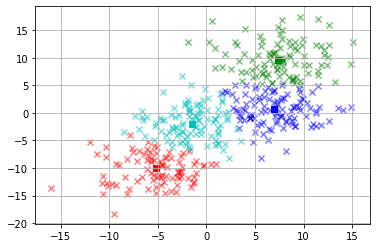

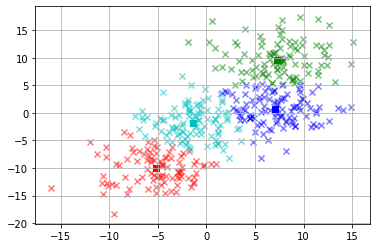

In [4]:
# Display plots here
plot_data(X,Z,C)
plot_data(X,Z2,C2)

### Discuss
Discuss the difference between models with different type of covariance matrices here.

__PLEASE WRITE YOUR ANSWER HERE__

For the most part, these models behaved exactly the same. On the boundaries between clusters, we notice that the top plot(diagonal covariance) has more points overlapping(ex: the teal/blue points at ~(3,-3)). On the plot of the second model(spherical covariance), a few of these overlapping points are assigned to the same class, not overlapping anymore (ex: the same two points at (3,-3) are both teal).In this sense, the second model was very slightly better at creating stricter,non-overlapping cluster boundaries than the first model. 

## Part 2: Gaussian mixture model and GD (10 points)

In this part you need to implement GMM training using gradient descent. You will use `jax` for automatic differention package to compute the gradient.

In [5]:
# Import dependencies
import jax.numpy as np
from jax import grad, jit

### Data
Generate 400 samples randomly split between 4 clusters. Sample code below is with `cluster_std` of 1 and `center_box` in (-5,5).

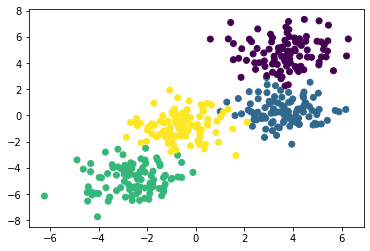

In [6]:
# Generate data
N = 400 # number of samples
n_components = 4 # number of clusters
d = 2 # data dimension
std_div = 1

X, Y = make_blobs(n_samples=N, centers=n_components, n_features=d, cluster_std=std_div, center_box = (-5,5),
                  random_state=random_seed)
plt.figure()
plt.scatter(X[:,0], X[:,1], c=Y)
plt.show()

### Parameters initialization
Initialize prior distribution and cluster means using function skeleton below.

### Attention: the prior is the probability $\pi_k$ of each cluster $k$ with $\sum_{k=1}^K \pi_k = 1$.

In [7]:
def initialize_parameters(n_samples, n_components, cluster_std=1):
    """
    Input
        n_samples: number of data points
        n_components: number of clusters 
    Output
        prior: the prior probability of each cluster, initialized at (1/n_components), (n_components)
        mu: randomly initialized clusters, (n_components, d)
    """
    prior = [1/n_components for i in range(n_components)]
    #Just use the first n_components elements of X, which is currently in scope
    mu = [X[y] for y in range(n_components)]
    return prior, mu

### Conditional probability 
### (previously Likelihood but name changed to avoid confusion)
Compute the conditional probability of each data sample wrt each cluster center according to:

$$p(x~|~z_k)\sim\mathcal{N}(x| \mu_k, \Sigma_k)$$ 

where you can assume that $\Sigma_k$ is the identity.

In [32]:
def conditional_probability(X, mu):
    """
    Funciton which computes the likelihood of observed data given cluster centers: p(X|Z)
    Input
        X: data points, (n_samples x d)
        mu: cluster centers, (n_components x d)
    Outout
        likelihood: likelihood of X for each cluster, (n_samples x n_clusters)
    """
    return np.concatenate([np.array((np.exp(-0.5*np.power(X - mu[i,:],2).sum(axis=1).reshape(len(X),1)))/(2*np.pi)) for i in range(len(mu))],axis = 1)


### Marginalized negative log-likelihood
Using the likelihood:

$$ p(x_i) = \sum_{k=1}^K \pi_k \cdot p(x_i~|~z_k), $$

compute the marginalized negative log-likelihood of the data $X$: 

$$\mathrm{NLL} = -\sum_{i=1}^N \log(p(x_i)).$$ 

You should find the $\mathrm{conditional\_probability}$ function from above helpful.

In [33]:
# Compute the marginalized negative log-likelihood 
def neg_ll(prior, mu, X):
    """
    Input
        prior: the probability of each cluster, (n_components)
        mu: clusters, (n_components, n_features)
        X: data samples, (n_samples x d)
    Output:
        nll:marginalized negative log-likelihood, scalar
    """
    likelihood = conditional_probability(X,mu)
    nll = (-np.log(likelihood @ prior)).sum(axis=0)
    return nll

### Gradient using jax
Use `jax` to keep track of the gradient with respect to the parameters (prior and means).

In [34]:
# Gradient function for marginalized negative log-likelihood wrt to prior and means mu

grad_nll = jit(grad(neg_ll,argnums=[0,1]))

### Training GMM with GD
Implement the GMM training with gradient descent.

In [35]:
# GMM with gradient descent
def gmm_gd(X, n_components, n_iter=10000, eta=1e-2, threshold=1e-2):
    """
    Input 
        X: data points, (n_samples x d)
        n_components: number of clusters
        n_iter: maximal number of training loop iterations, integer with default value of 10000 
        eta: learning rate for gradient descent, float with default value of 1e-2
        threshold: threshold for stopping criteria, float with default value of 1e-2
    Output:
        cluster_assignments: cluster assignment of each data sample, (n_samples, )
        mu: cluster centers, (n_components x d)
    """
    
    # Initialize parameters
    prior, mu = initialize_parameters(len(X), n_components)
    
    # Turn into jax.numpy array
    prior, mu = np.array(prior), np.array(mu)
    
    # Plot initialization 
    plot_data(X, Z=None, C=mu)
    
    # Training loop
    prev_cost = None
    for ni in range(n_iter):
        
        # Compute gradients for the prior and cluster means
        d_prior, d_mu = grad_nll(prior,mu,X) #TODO
        
        # Take a gradient step for the prior and cluster means
        prior -= eta * d_prior
        mu -= eta * d_mu   
        
        # Normalize the prior probabilities so that they sum to 1 for each data sample
        prior = prior / sum(prior)

        # Compute the cost
        cost = neg_ll(prior, mu, X)
        
        # Log cost
        if (ni + 1) % 100 == 0 or (ni + 1) == n_iter or ni == 0:
            print("Iter {} cost: {:.2f}".format(ni+1, cost))
        
        # Early stopping
        if prev_cost is not None and prev_cost - cost < threshold:
            print("Iter {} cost: {:.2f}".format(ni+1, cost))
            break
        prev_cost = cost
        
    # Assign clusters
    
    cluster_assignments = [0 for x in X]
    for i in range(len(X)):
        for j in range(len(mu)):
            if(numpy.linalg.norm(X[i]-mu[j]) < numpy.linalg.norm(X[i]-mu[cluster_assignments[i]])):
                cluster_assignments[i]=j
    
    return np.array(cluster_assignments), mu

### Data
Generate 400 samples randomly split between 4 clusters with `cluster_std` of 1 and `center_box` in (-5,5).

Train a GMM with GD on the data generated in the first step.

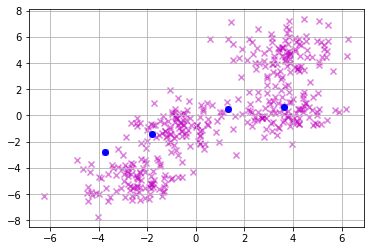

Iter 1 cost: 1968.19
Iter 13 cost: 1692.17


In [36]:
# Train GMM with GD
Z_gd, C_gd = gmm_gd(X, 4)

Plot the learned cluster means and assignments.

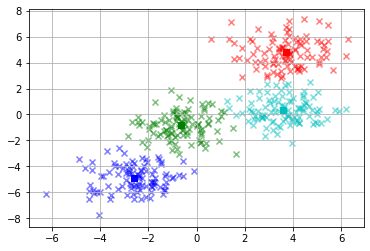

In [38]:
# Plot means and assignments
plot_data(X, Z_gd, C_gd)